[]


IndexError: ignored

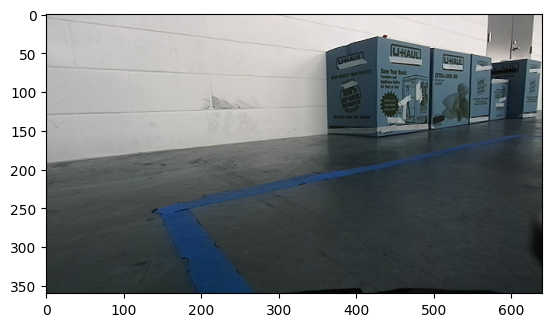

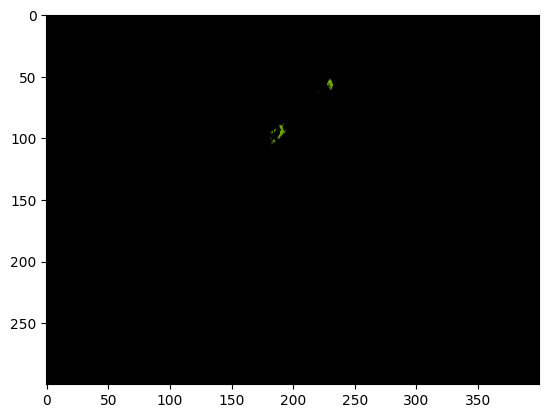

In [191]:
import cv2
import numpy as np

#################### X-Y CONVENTIONS #########################
# 0,0  X  > > > > >
#
#  Y
#
#  v  This is the image. Y increases downwards, X increases rightwards
#  v  Please return bounding boxes as ((xmin, ymin), (xmax, ymax))
#  v
#  v
#  v
###############################################################

WIDTH = 400
HEIGHT = 300
SCALE = 100
CENTER = WIDTH // 2

def image_print(img):
	"""
	Helper function to print out images, for debugging. Pass them in as a list.
	Press any key to continue.
	"""
	cv2.imshow("image", img)
	cv2.waitKey(0)
	cv2.destroyAllWindows()
 

def homography_matrix():
    PTS_IMAGE_PLANE =   [[180, 172],
                [315,226],
                [331, 170],
                [494, 159],
                [432, 210],
                [217, 220], 
                #FROM homography1
                [303, 367],
                [547, 361]]

    PTS_GROUND_PLANE = [[110.0, 50.0],
                [30.0, 0.0],
                [110, 0.0],
                [110.0, -50.0],
                [30.0, -10.0],
                [30.0, 10.0],
                #FROM HOMOGRAPHY1
                [10.0, 0.0],
                [10.0, -8.0]]

    METERS_PER_INCH = 0.0254

    if not len(PTS_GROUND_PLANE) == len(PTS_IMAGE_PLANE):
        rospy.logerr("ERROR: PTS_GROUND_PLANE and PTS_IMAGE_PLANE should be of same length")

    np_pts_ground = np.array(PTS_GROUND_PLANE)
    np_pts_ground = np_pts_ground * METERS_PER_INCH
    np_pts_ground = np.float32(np_pts_ground[:, np.newaxis, :])

    np_pts_ground = np_pts_ground * SCALE
    np_pts_ground[:, :, 1] += CENTER
    np_pts_ground = np_pts_ground[:, :, ::-1]

    np_pts_image = np.array(PTS_IMAGE_PLANE)
    np_pts_image = np.float32(np_pts_image[:, np.newaxis, :])

    h, err = cv2.findHomography(np_pts_image, np_pts_ground)

    return h

def transform_image(img):
    #convert to hsv
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #for line following, convert img to img_line

    # kernel = np.ones((20,20),np.float32)/25
    # dst = cv2.filter2D(img_hsv,-1,kernel)

    #filter oranges
    # light_orange = (20, 105, 99) #H,S,V (0, 210, 170)
    # dark_orange = (50, 220, 190) #H,S,V (50, 255, 255)
    # light_orange = (10, 115, 120) #H,S,V (0, 210, 170)
    # dark_orange = (45, 220, 200) #H,S,V (50, 255, 255)

    light_orange = (10, 110, 120) #H,S,V (0, 210, 170)
    dark_orange = (45, 220, 200) #H,S,V (50, 255, 255)
    mask = cv2.inRange(img_hsv, light_orange, dark_orange)
    img = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)
    # plt.figure()
    # plt.imshow(masked_img)

    height, width, channels = img.shape
    height_cutoff = int(height*0.39)

    img[:int(height_cutoff), 0:width] = 0

    img = cv2.warpPerspective(img, homography_matrix(), (WIDTH, HEIGHT))
    return img

def convert_line_to_world(line):
  x1, y1, x2, y2 = line[0]
  return [(x1 * 1.0 - CENTER * 1.0) / (SCALE * 1.0), y1 / (SCALE*1.0), (x2 * 1.0 - CENTER * 1.0) / (SCALE * 1.0), y2 / (SCALE*1.0)]
  return [(i * 1.0 - CENTER * 1.0) / (SCALE * 1.0) for i in line[0]]

def cd_color_segmentation(img, template):
    """
    Implement the cone detection using color segmentation algorithm
    Input:
      img: np.3darray; the input image with a cone to be detected. BGR.
      template_file_path; Not required, but can optionally be used to automate setting hue filter values.
    Return:
      bbox: ((x1, y1), (x2, y2)); the bounding box of the cone, unit in px
          (x1, y1) is the top left of the bbox and (x2, y2) is the bottom right of the bbox
    """
    ########## YOUR CODE STARTS HERE ##########



    linesP = cv2.HoughLinesP(img[:, :, 0], rho=1, theta=np.pi/180, threshold=40, minLineLength=35, maxLineGap=6)

    if(not type(linesP) is np.ndarray):
        return img, [], False
    
    line = linesP[0]
    known_m = [(line[0][3]*1.0 - line[0][1]*1.0) / (line[0][2]*1.0 - line[0][0]*1.0)]
    known_b = [line[0][1] - known_m[0] * line[0][0]]
    # known_m = []
    # known_b = []
    lines = [line]
    # print("LINES", lines)

    for line in linesP:
      m = (line[0][3]*1.0 - line[0][1]*1.0) / (line[0][2]*1.0 - line[0][0]*1.0)
      b = line[0][1] - m * line[0][0]
      m_thresh = 1.1
      
      addline = True
      for i in range(len(known_m)):
        if (abs(m - known_m[i]) < abs(0.3 * m)) and (abs(b - known_b[i]) < abs(0.3 * b)):
          addline = False

      if(addline):
         known_m.append(m)
         known_b.append(b)
         lines.append([[line[0][0], line[0][1], line[0][2], line[0][3]]])
    
    world_lines = [convert_line_to_world(i) for i in lines]
    
    # for i in lines:
    #   plt.plot([i[0][0], i[0][2]], [i[0][1], i[0][3]])
    return img, world_lines, True

import matplotlib.pyplot as plt

names = ["city1.png", 'cityc1.png', 'cityc2.png', 'cityend.png', 'cityend2.png', 'citystartleft.png', 'citystartr.png']


# for NAME in names:
#   print(NAME)
NAME = 'turn2.png'
plt.figure()
img = cv2.imread(NAME)
plt.imshow(img)

img = cv2.imread(NAME)
img = transform_image(img)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img, lines, found = cd_color_segmentation(img, '')


print(lines)
lines = lines[0]
lines[0]
lines[1]

In [186]:
def drive_command(goalx, goaly):
    eta = np.arctan2(goaly, goalx)
    angle = np.arctan2(2 * 0.32 * np.sin(eta), np.sqrt(goalx**2 + goaly**2))
    return angle


def pure_pursuit(lines):
  [x1, y1, x2, y2] = lines
  carx1, cary1, carx2, cary2 = y1, x1, y2, x2
  goalx = (carx1*1.0 + carx2*1.0) / 2
  goaly = (cary1*1.0 + cary2*1.0) / 2
  print(drive_command(goalx, goaly) / np.pi * 180)

pure_pursuit(lines)

-23.37214217245887
